In [1]:
!pip install -q lpips

# Imports and config


In [ ]:
from glob import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.utils
from torchvision import transforms
import wandb
from accelerate import Accelerator
from PIL import Image
from scipy.ndimage import distance_transform_edt
import numpy as np
import os
import json

import wandb
import lpips
import matplotlib.pyplot as plt


All libraries installed and imported successfully.


In [3]:
import os, wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

try:
    wandb_api_key = user_secrets.get_secret("WANDB_TOKEN")
    
    wandb.login(key=wandb_api_key)
    print("✅ Weights & Biases login successful.")
except:
    print("Could not log into W&B. Please ensure 'WANDB_TOKEN' is set in Kaggle Secrets.")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: parvp to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ Weights & Biases login successful.


In [4]:
# Experiment configuration
def default_config():
    return {
        'project': 'polygon-coloring',
        'run_name': 'final-upload',
        'batch_size': 16,
        'lr': 1e-4,
        'epochs': 120,
        'img_size': 128,
        'colors': ['red','green','blue','yellow','cyan','magenta','purple', 'orange'],
        'base_ch': 64,  
        'color_embed_dim': 32,         # Dimension for the color embedding
        'data_root': '/kaggle/input/polygon-coloring/dataset',
        'lpips_weight': 0.5,
    }
    

CONFIG = default_config()
wandb.init(project=CONFIG['project'], name=CONFIG['run_name'], config=CONFIG, notes="push model")
accelerator = Accelerator()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Configuration loaded. Using device: {DEVICE}")

Configuration loaded. Using device: cuda


# Dataset

In [ ]:

COLORS_TO_ID = {
    'red': 0, 'green': 1, 'blue': 2, 'yellow': 3,
    'cyan': 4, 'magenta': 5, 'purple': 6, 'orange': 7

}
NUM_COLORS = len(COLORS_TO_ID)

class PolygonDataset(Dataset):
    """
    This dataset version provides:
    1. x_outline: A 3-channel RGB outline image.
    2. y_rgb: The 3-channel ground-truth colored image.
    3. color_id: The numerical ID of the color.
    """
    def __init__(self, root_dir, split, img_size):
        self.img_size = img_size
        base_path = os.path.join(root_dir, split)
        json_path = os.path.join(base_path, 'data.json')
        
        # Using the global COLORS_TO_ID map
        self.COLORS_TO_ID = COLORS_TO_ID

        with open(json_path) as f:
            self.items = json.load(f)
            
        self.base_path = base_path
        self.transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        item = self.items[idx]
        
        # Load images
        input_path = os.path.join(self.base_path, 'inputs', item['input_polygon'])
        output_path = os.path.join(self.base_path, 'outputs', item['output_image'])
        img_in = Image.open(input_path).convert('RGB')
        img_out = Image.open(output_path).convert('RGB')
        
        x_outline_rgb = self.transform(img_in)
        y_rgb = self.transform(img_out)
        
        color_name = item['colour']
        color_id = torch.tensor(self.COLORS_TO_ID.get(color_name, 7), dtype=torch.long)
        
        return x_outline_rgb, y_rgb, color_id

print("Dataset class 'PolygonDataset' defined.")

Dataset class 'PolygonDataset_Final' defined.


# Model

In [11]:
class ResBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.block = nn.Sequential(nn.GroupNorm(8, ch), nn.SiLU(), nn.Conv2d(ch, ch, 3, padding=1), nn.GroupNorm(8, ch), nn.SiLU(), nn.Conv2d(ch, ch, 3, padding=1))
    def forward(self, x): return x + self.block(x)

class CrossAttention(nn.Module):
    def __init__(self, query_dim, context_dim, heads=8, dim_head=32):
        super().__init__()
        self.heads, self.dim_head = heads, dim_head
        self.scale = dim_head ** -0.5
        inner_dim = dim_head * heads
        self.to_q, self.to_k, self.to_v = nn.Linear(query_dim, inner_dim, bias=False), nn.Linear(context_dim, inner_dim, bias=False), nn.Linear(context_dim, inner_dim, bias=False)
        self.to_out = nn.Linear(inner_dim, query_dim)
    def forward(self, x, context):
        B, N, C = x.shape
        q, k, v = self.to_q(x), self.to_k(context), self.to_v(context)
        q, k, v = map(lambda t: t.view(B, -1, self.heads, self.dim_head).transpose(1, 2), (q, k, v))
        scores = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = F.softmax(scores, dim=-1)
        out = torch.matmul(attn, v).transpose(1, 2).contiguous().view(B, N, -1)
        return self.to_out(out)

class CrossAttnUpBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch, color_embed_dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv = nn.Sequential(nn.Conv2d(in_ch + skip_ch, out_ch, 3, padding=1), ResBlock(out_ch))
        self.attn = CrossAttention(query_dim=out_ch, context_dim=color_embed_dim)
        self.norm1 = nn.LayerNorm(out_ch)
        self.norm2 = nn.LayerNorm(out_ch) 

    def forward(self, x, skip, color_context):
        x = self.up(x); x = torch.cat([x, skip], dim=1); x = self.conv(x)
        B, C, H, W = x.shape
        x_flat = x.view(B, C, -1).permute(0, 2, 1)
        attn_out = self.attn(self.norm1(x_flat), color_context)
        x_flat = self.norm2(x_flat + attn_out) # <-- Apply normalization after residual
        x = x_flat.permute(0, 2, 1).view(B, C, H, W)
        return x

class CrossAttnUNet(nn.Module):
    """A 2-Level version of our stable UNet."""
    def __init__(self, in_ch=3, out_ch=3, base_ch=64, color_embed_dim=64):
        super().__init__()
        # --- 2-Level Encoder ---
        self.enc1 = nn.Sequential(nn.Conv2d(in_ch, base_ch, 3, padding=1), ResBlock(base_ch))
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(nn.Conv2d(base_ch, base_ch * 2, 3, padding=1), ResBlock(base_ch * 2))
        self.pool2 = nn.MaxPool2d(2)
        self.bot = ResBlock(base_ch * 2)

        # --- 2-Level Decoder with Cross-Attention ---
        self.dec2 = CrossAttnUpBlock(base_ch * 2, base_ch * 2, base_ch, color_embed_dim)
        self.dec1 = CrossAttnUpBlock(base_ch, base_ch, base_ch, color_embed_dim)
        
        self.final_conv = nn.Conv2d(base_ch, out_ch, 1)

    def forward(self, x_outline, color_embedding):
        color_context = color_embedding.unsqueeze(1)
        x1 = self.enc1(x_outline); p1 = self.pool1(x1)
        x2 = self.enc2(p1); p2 = self.pool2(x2)
        b = self.bot(p2)
        d2 = self.dec2(b, x2, color_context)
        d1 = self.dec1(d2, x1, color_context)
        return torch.sigmoid(self.final_conv(d1))
print("UNet 2 levels only architecture.")


UNet 2 levels only architecture ready for 3-channel input.


# Training Loop

In [8]:
train_dataset = PolygonDataset(root_dir=CONFIG['data_root'], split='training', img_size=CONFIG['img_size'])
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2)
val_dataset = PolygonDataset(root_dir=CONFIG['data_root'], split='validation', img_size=CONFIG['img_size'])
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)

model = CrossAttnUNet(in_ch=3, out_ch=3, base_ch=CONFIG['base_ch'], color_embed_dim=CONFIG['color_embed_dim']).to(DEVICE)
color_embedding_layer = nn.Embedding(NUM_COLORS, CONFIG['color_embed_dim']).to(DEVICE)
optimizer = torch.optim.Adam(list(model.parameters()) + list(color_embedding_layer.parameters()), lr=CONFIG['lr'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'], eta_min=1e-6)
criterion_l1 = nn.L1Loss()
criterion_lpips = lpips.LPIPS(net='alex').to(DEVICE)

val_log_batch = next(iter(val_loader))

print("--- Starting Training with Simple Global Loss ---")
for epoch in range(CONFIG['epochs']):
    model.train(); color_embedding_layer.train()
    total_train_loss = 0.0
    
    for x_outline, y_rgb, color_ids in train_loader:
        x_outline, y_rgb, color_ids = x_outline.to(DEVICE), y_rgb.to(DEVICE), color_ids.to(DEVICE)
        optimizer.zero_grad()
        
        color_embed = color_embedding_layer(color_ids)
        # Pass the 3-channel outline to the model
        pred_rgb = model(x_outline, color_embed)
        
        
        loss_l1 = criterion_l1(pred_rgb, y_rgb)
        loss_perceptual = criterion_lpips(pred_rgb, y_rgb).mean()
        loss = loss_l1 + CONFIG.get('lpips_weight', 0.5) * loss_perceptual
        
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
        
    model.eval(); color_embedding_layer.eval()
    avg_val_loss = 0.0
    with torch.no_grad():
        for x_outline, y_rgb, color_ids in val_loader:
            x_outline, y_rgb, color_ids = x_outline.to(DEVICE), y_rgb.to(DEVICE), color_ids.to(DEVICE)
            color_embed = color_embedding_layer(color_ids)
            pred_rgb = model(x_outline, color_embed)
            
            loss_l1 = criterion_l1(pred_rgb, y_rgb)
            loss_perceptual = criterion_lpips(pred_rgb, y_rgb).mean()
            avg_val_loss += (loss_l1 + CONFIG.get('lpips_weight', 0.5) * loss_perceptual).item()
    
    scheduler.step()
    avg_val_loss /= len(val_loader)
    print(f"Epoch {epoch+1:03d}: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.2e}")
    wandb.log({'epoch': epoch + 1, 'train_loss': avg_train_loss, 'val_loss': avg_val_loss, 'lr': scheduler.get_last_lr()[0]})

    with torch.no_grad():
        x_outline_log, y_rgb_log, color_ids_log = val_log_batch
        x_outline_log, y_rgb_log, color_ids_log = x_outline_log.to(DEVICE), y_rgb_log.to(DEVICE), color_ids_log.to(DEVICE)
        
        color_embed = color_embedding_layer(color_ids_log)
        pred_rgb = model(x_outline_log, color_embed)
        
        log_images = torch.cat([x_outline_log.cpu(), y_rgb_log.cpu(), pred_rgb.cpu()], dim=0)
        grid = torchvision.utils.make_grid(log_images, nrow=x_outline_log.shape[0], normalize=True)
        wandb.log({"predictions": wandb.Image(grid, caption=f"Top: Input, Middle: GT, Bottom: Pred @ Epoch {epoch+1}")})

print("--- Training Finished ---")
torch.save(model.state_dict(), "stable_unet_global_loss.pth")
torch.save(color_embedding_layer.state_dict(), "embedding_global_loss.pth")
wandb.finish()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
--- Starting Training with Simple Global Loss ---
Epoch 001: Train Loss: 0.5297 | Val Loss: 0.3122 | LR: 1.00e-04
Epoch 002: Train Loss: 0.3605 | Val Loss: 0.2610 | LR: 9.99e-05
Epoch 003: Train Loss: 0.3150 | Val Loss: 0.2445 | LR: 9.98e-05
Epoch 004: Train Loss: 0.2994 | Val Loss: 0.2372 | LR: 9.97e-05
Epoch 005: Train Loss: 0.2932 | Val Loss: 0.2333 | LR: 9.96e-05
Epoch 006: Train Loss: 0.2818 | Val Loss: 0.2308 | LR: 9.94e-05
Epoch 007: Train Loss: 0.2777 | Val Loss: 0.2286 | LR: 9.92e-05
Epoch 008: Train Loss: 0.2796 | Val Loss: 0.2267 | LR: 9.89e-05
Epoch 009: Train Loss: 0.2772 | Val Loss: 0.2222 | LR: 9.86e-05
Epoch 010: Train Loss: 0.2700 | Val Loss: 0.2225 | LR: 9.83e-05
Epoch 011: Train Loss: 0.2685 | Val Loss: 0.2203 | LR: 9.80e-05
Epoch 012: Train Loss: 0.2659 | Val Loss: 0.2201 | LR: 9.76e-05
Epoch 013: Train Loss: 0.2629 | Val Loss: 0.2219 | LR: 9.72e-05
Epoch 014: Train Loss: 0.2557 

epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇██
lr,█████████▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▂▂▂▂▂▁▁▁▁
train_loss,██▇▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▄▃▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
val_loss,███▇▇▇▆▆▆▅▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,120
lr,0.0
train_loss,0.04826
val_loss,0.04773


# Visualize Output

Generating 5 comparison images from the live model...


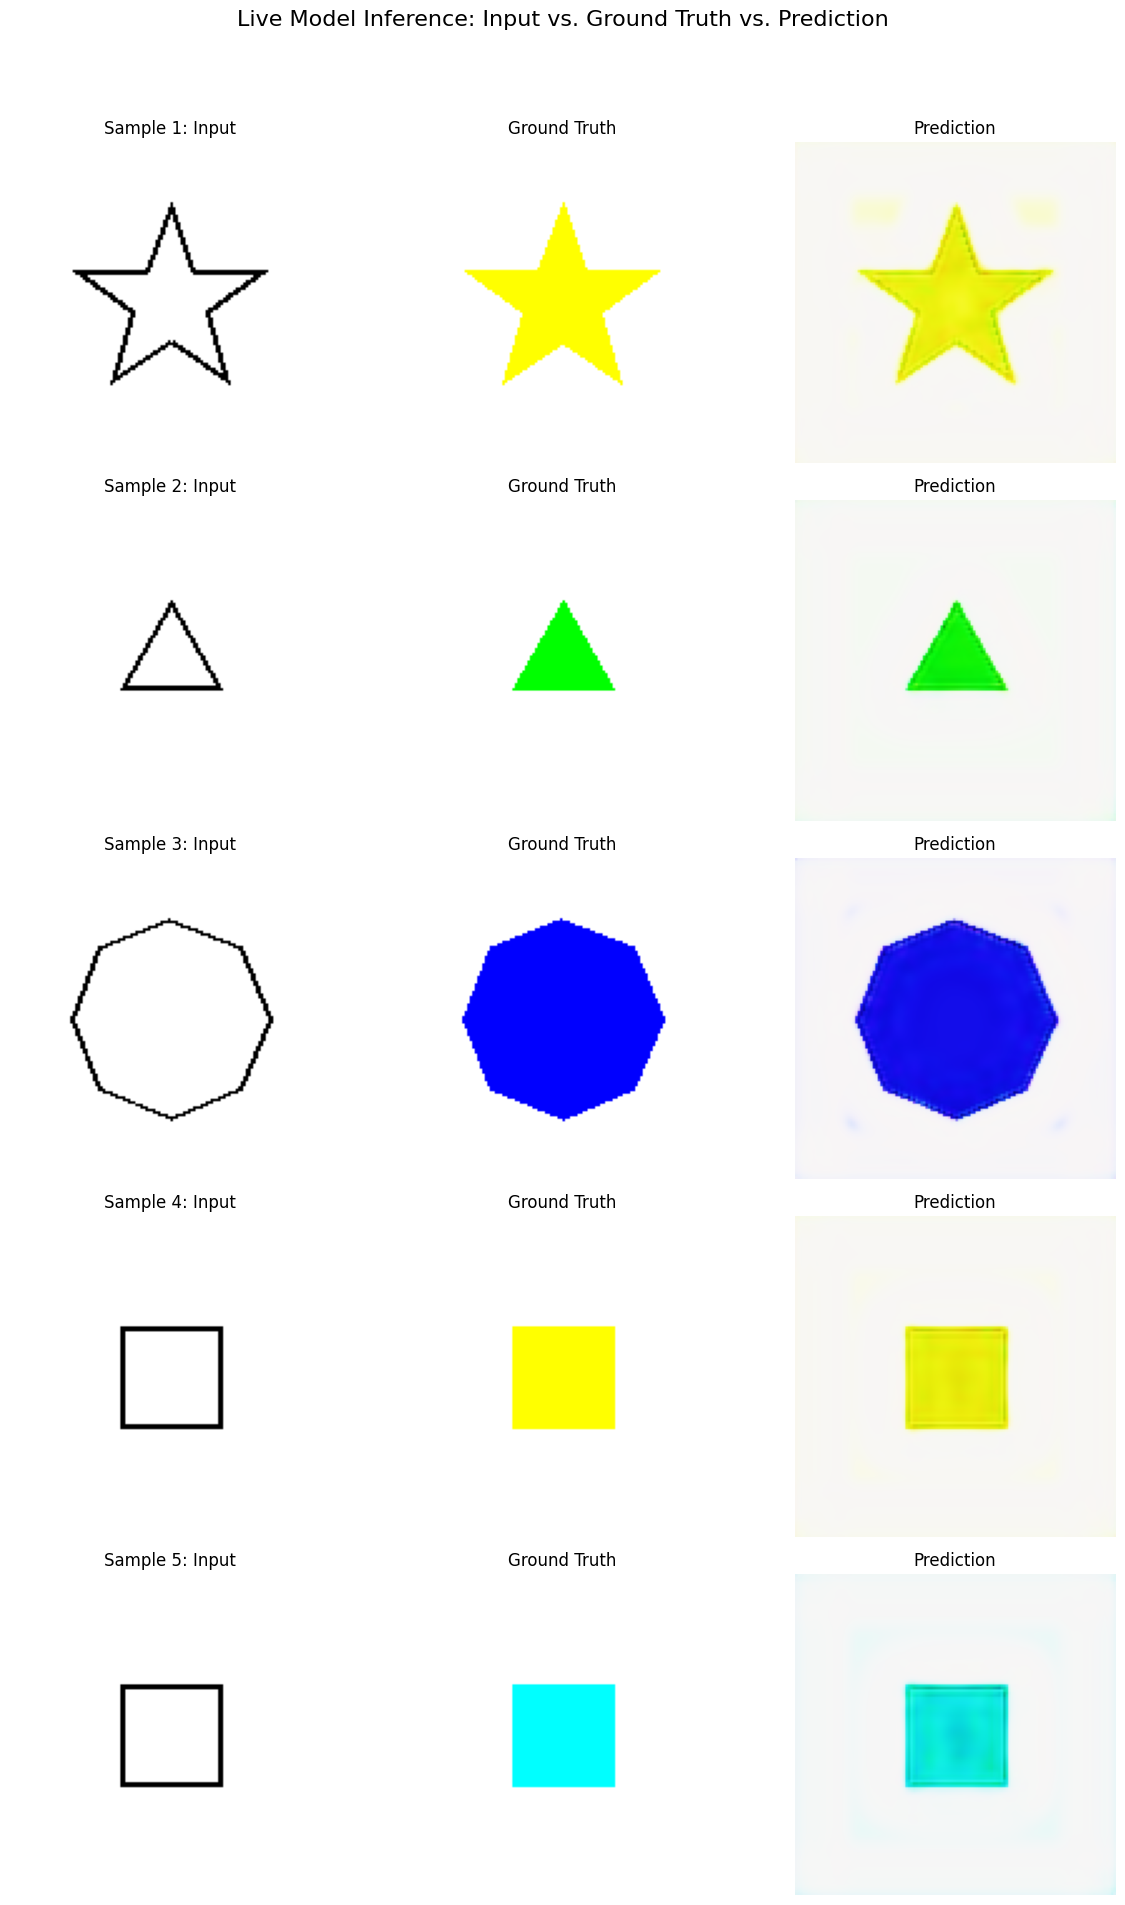

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_comparison(model_in_memory, embedding_layer_in_memory, dataset, device, num_samples=5):
    """
    Generates a side-by-side comparison of the input, ground truth, and prediction
    using the trained model variable currently in memory.
    """
    
    # Set models to evaluation mode
    model_in_memory.eval()
    embedding_layer_in_memory.eval()
    
    print(f"Generating {num_samples} comparison images from the live model...")

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))
    fig.suptitle("Live Model Inference: Input vs. Ground Truth vs. Prediction", fontsize=16)

    with torch.no_grad():
        for i in range(num_samples):
            # Get a sample from the validation dataset
            input_outline_rgb, ground_truth_rgb, color_id = dataset[i]
            
            # Prepare tensors for the model by adding a batch dimension
            input_tensor = input_outline_rgb.unsqueeze(0).to(device)
            color_id_tensor = color_id.unsqueeze(0).to(device)
            
            # --- Get the model's prediction ---
            color_embed = embedding_layer_in_memory(color_id_tensor)
            predicted_rgb = model_in_memory(input_tensor, color_embed)

            # --- Prepare all three images for plotting ---
            input_img = input_outline_rgb.permute(1, 2, 0).numpy()
            gt_img = ground_truth_rgb.permute(1, 2, 0).numpy()
            pred_img = predicted_rgb.squeeze(0).cpu().permute(1, 2, 0).numpy()
            
            # --- Display the images side-by-side ---
            # Column 1: Input Outline
            axes[i, 0].imshow(input_img)
            axes[i, 0].set_title(f"Sample {i+1}: Input")
            axes[i, 0].axis('off')
            
            # Column 2: Ground Truth
            axes[i, 1].imshow(gt_img)
            axes[i, 1].set_title("Ground Truth")
            axes[i, 1].axis('off')
            
            # Column 3: Model Prediction
            axes[i, 2].imshow(pred_img)
            axes[i, 2].set_title("Prediction")
            axes[i, 2].axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Execute the visualization ---
# This uses the 'model', 'color_embedding_layer', 'val_dataset', and 'DEVICE'
# variables that should already be available from your training cell.

visualize_comparison(model, color_embedding_layer, val_dataset, DEVICE, num_samples=5)